In [166]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

## Drafting EDA

In [135]:
# Load the training from CSV files
train_data = pd.read_csv("./train_cleaned.csv")

In [136]:
train_data.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,58,1.0,0,0.0,0.0,0,0,0,220.0,143.0,104.0,29.85,75,87.000000,1
1,0,40,1.0,1,15.0,0.0,0,0,0,199.0,122.0,82.0,22.16,85,77.000000,0
2,0,52,1.0,0,0.0,0.0,0,0,0,275.0,112.0,71.0,25.68,80,79.380242,0
3,1,38,2.0,1,43.0,0.0,0,1,0,170.0,130.0,94.0,23.90,110,75.000000,0
4,0,43,1.0,0,0.0,0.0,0,0,0,202.0,124.0,92.0,21.26,75,74.000000,0


### KDE Plots

NOTE: A lot of the KDE plots look the same & have a regular normal distribution. We could get rid of the normal plots and include the KDE plot for cigs per day and focus on that. I also included a box plot, which kinda represents the same thing as a kdeplot.

<Axes: xlabel='age', ylabel='Density'>

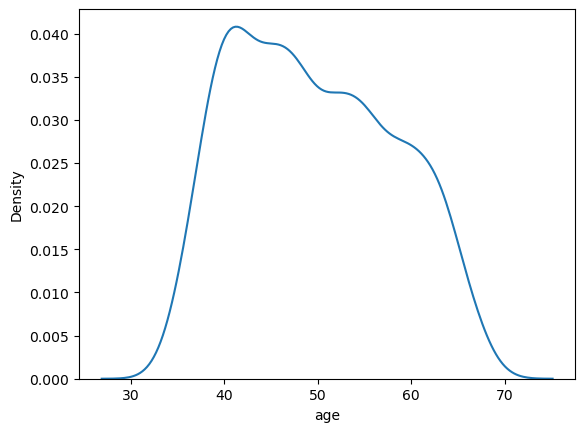

In [137]:
sns.kdeplot(train_data, x=train_data['age'])

<Axes: xlabel='totChol', ylabel='Density'>

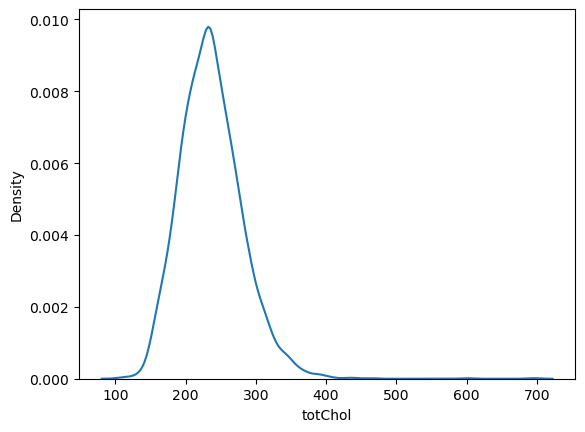

In [138]:
sns.kdeplot(train_data, x=train_data['totChol'])

<Axes: xlabel='sysBP', ylabel='Density'>

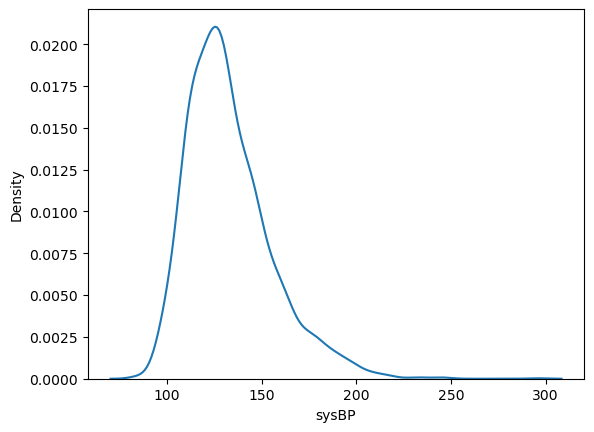

In [139]:
sns.kdeplot(train_data, x=train_data['sysBP'])


<Axes: xlabel='diaBP', ylabel='Density'>

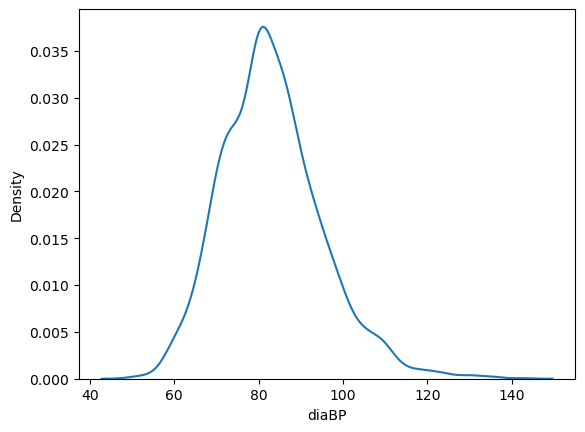

In [140]:
sns.kdeplot(train_data, x=train_data['diaBP'])

<Axes: xlabel='BMI', ylabel='Density'>

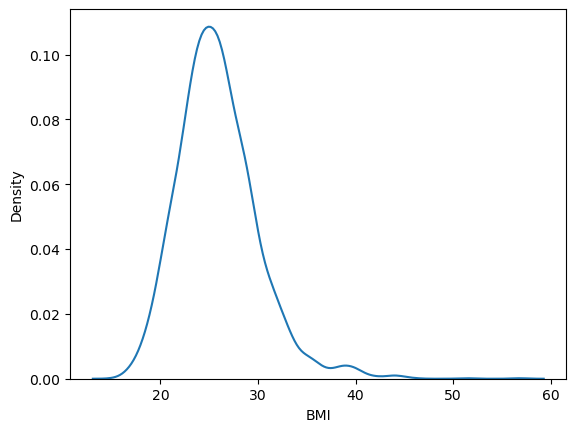

In [141]:
sns.kdeplot(train_data, x=train_data['BMI'])

<Axes: xlabel='cigsPerDay', ylabel='Density'>

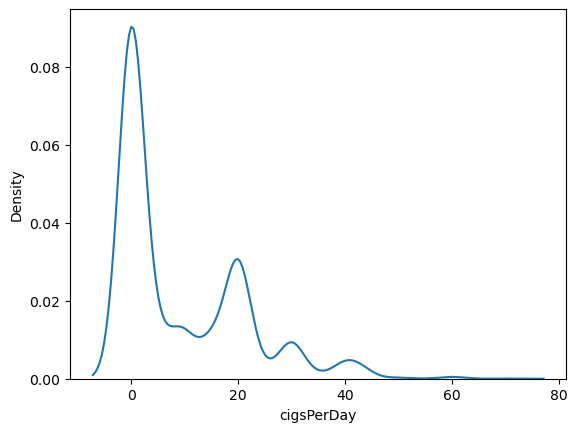

In [142]:
sns.kdeplot(train_data, x=train_data['cigsPerDay'])

<Axes: xlabel='heartRate', ylabel='Density'>

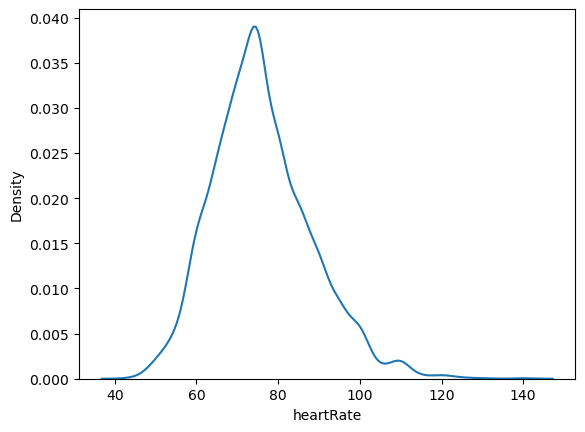

In [143]:
sns.kdeplot(data=train_data, x=train_data['heartRate'])

> All the continuous variables are unimodal other than cigsPerDay. This is because the participants are split between smokers and non-smokers, so there is a significant peak at 0 for the non-smokers. Then, the frequencies fluctuate as the number of cigsPerDay increases.

### Correlation & Outliers

In [144]:
# Define outliers method
def outliers(data, column_name):
    # Calculate Q1 and Q3 of the column
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    
    # Calculate the IQR
    IQR = Q3 - Q1
    
    # Determine the outlier cutoffs
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outliers = (data[column_name] < lower_bound) | (data[column_name] > upper_bound)

    print(outliers.sum())
    # Single out points that are outliers
    # print(outliers[outliers])

In [145]:
for column in train_data.columns:
  print(f"Outliers for {column}: ")
  outliers(train_data, column)
  print("\n")

Outliers for sex: 
0


Outliers for age: 
0


Outliers for education: 
0


Outliers for currentSmoker: 
0


Outliers for cigsPerDay: 
10


Outliers for BPMeds: 
94


Outliers for prevalentStroke: 
21


Outliers for prevalentHyp: 
0


Outliers for diabetes: 
83


Outliers for totChol: 
47


Outliers for sysBP: 
102


Outliers for diaBP: 
57


Outliers for BMI: 
76


Outliers for heartRate: 
58


Outliers for glucose: 
199


Outliers for TenYearCHD: 
487




In [146]:
# Split data in half so boxplots are easier to see
df_bp = train_data.loc[:, ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]


<Axes: >

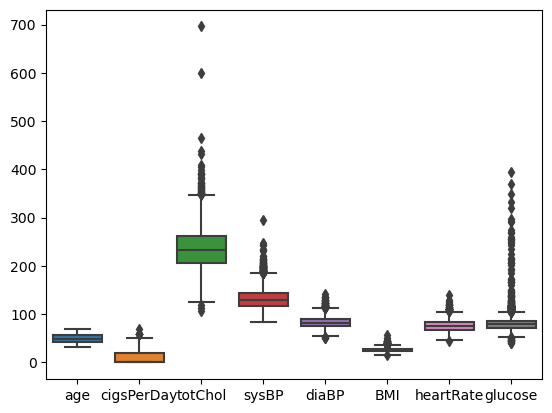

In [147]:
sns.boxplot(data=df_bp)

Based on the boxplots, we see some badly scaled variables:

- **totChol** and **glucose**: These variables show a significantly wider range and larger values - compared to others, indicating they are on a different scale.
- **sysBP** and **diaBP**: Systolic and diastolic blood pressures also appear to have a larger range, although not as pronounced as totChol and glucose.
- **age, cigsPerDay, BMI**, and **heartRate**: These variables have a much narrower range and smaller values, hence they are scaled differently compared to totChol and glucose.

Candidates for log transformation:
- **totChol**: Since this variable has a long tail with extreme values, it might benefit from a log transformation to compress the scale and normalize the distribution.
- **glucose**: Similar to totChol, it has a positive skew with some extreme values that could be normalized with a log transformation.
- **sysBP**: Though not as extreme as totChol and glucose, it has a positive skew.


<Axes: >

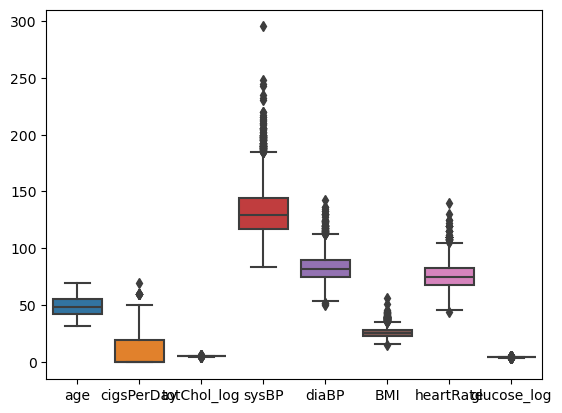

In [149]:
train_data['totChol_log'] = np.log(train_data['totChol'])
train_data['glucose_log'] = np.log(train_data['glucose'])
# train_data['sysBP_log'] = np.log(train_data['sysBP'])
# train_data['BMI_log'] = np.log(train_data['BMI'])
train_data = train_data.drop(['totChol', 'glucose'], axis=1)
sns.boxplot(data=train_data.loc[:, ['age', 'cigsPerDay', 'totChol_log', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose_log']])



In [150]:
train_data.corr()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,sysBP,diaBP,BMI,heartRate,TenYearCHD,totChol_log,glucose_log
sex,1.000000,-0.038939,0.006739,0.198117,0.325401,-0.043856,0.007104,0.010722,0.020140,-0.027647,0.064950,0.083549,-0.109369,0.097138,-0.065015,0.009162
age,-0.038939,1.000000,-0.174209,-0.216628,-0.199792,0.113578,0.064746,0.298794,0.094140,0.396181,0.207611,0.138060,-0.016787,0.225568,0.273612,0.116378
education,0.006739,-0.174209,1.000000,0.014687,0.006071,-0.013158,-0.031615,-0.083263,-0.040596,-0.138959,-0.067689,-0.147856,-0.074702,-0.052207,-0.024370,-0.042888
currentSmoker,0.198117,-0.216628,0.014687,1.000000,0.768088,-0.052526,-0.033461,-0.098607,-0.038440,-0.133829,-0.102881,-0.176126,0.064442,0.001644,-0.027160,-0.069629
cigsPerDay,0.325401,-0.199792,0.006071,0.768088,1.000000,-0.048729,-0.031091,-0.067828,-0.035730,-0.090804,-0.049933,-0.094976,0.080799,0.046104,-0.012030,-0.073460
BPMeds,-0.043856,0.113578,-0.013158,-0.052526,-0.048729,1.000000,0.123311,0.249816,0.052946,0.248394,0.196987,0.091196,-0.004864,0.090762,0.068706,0.026942
prevalentStroke,0.007104,0.064746,-0.031615,-0.033461,-0.031091,0.123311,1.000000,0.068668,-0.013348,0.056260,0.038972,0.004249,-0.024421,0.062357,-0.012683,0.006133
prevalentHyp,0.010722,0.298794,-0.083263,-0.098607,-0.067828,0.249816,0.068668,1.000000,0.081750,0.690353,0.614522,0.299784,0.146410,0.163910,0.163559,0.086540
diabetes,0.020140,0.094140,-0.040596,-0.038440,-0.035730,0.052946,-0.013348,0.081750,1.000000,0.104852,0.045949,0.085949,0.043512,0.105644,0.038048,0.516081
sysBP,-0.027647,0.396181,-0.138959,-0.133829,-0.090804,0.248394,0.056260,0.690353,0.104852,1.000000,0.788834,0.324774,0.169520,0.205898,0.207964,0.129526


> Based on the correlation matrix, the variables that are strongly associated with TenYearCHD are age (0.226), and systolic blood pressure (0.206).

In [151]:
binary_columns = ['sex', 'currentSmoker', 'education', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'BPMeds']
for c in binary_columns:
  print(train_data['TenYearCHD'].groupby(train_data[c]).describe())

      count      mean       std  min  25%  50%  75%  max
sex                                                     
0    1803.0  0.122573  0.328038  0.0  0.0  0.0  0.0  1.0
1    1377.0  0.193174  0.394931  0.0  0.0  0.0  0.0  1.0
                count      mean       std  min  25%  50%  75%  max
currentSmoker                                                     
0              1619.0  0.152563  0.359677  0.0  0.0  0.0  0.0  1.0
1              1561.0  0.153748  0.360822  0.0  0.0  0.0  0.0  1.0
            count      mean       std  min  25%  50%  75%  max
education                                                     
1.0        1310.0  0.190076  0.392511  0.0  0.0  0.0  0.0  1.0
2.0        1034.0  0.115087  0.319281  0.0  0.0  0.0  0.0  1.0
3.0         495.0  0.139394  0.346708  0.0  0.0  0.0  0.0  1.0
4.0         341.0  0.146628  0.354254  0.0  0.0  0.0  0.0  1.0
                  count      mean       std  min  25%  50%  75%  max
prevalentStroke                                          

> By looking at a summary table of TenYearCHD grouped by categorical variables, we see that there is a slight difference in the mean of women who have TenYearCHD than men (0.122 vs. 0.193). There doesn't seem to be a difference in average TenYearCHD for current vs. non-smoker, which is surprising considering general perspectives on heart health. In education, there is some variation in the averages of TenYearCHD. An education of "some high school" warrants the highest mean of 0.19 for that group, while "college" is second with a mean of 0.1466. For the proportion of the population that has prevalent strokes, the TenYearCHD average is almost 0.43, which is much higher than the population that's free of disease (0.15 average). The difference in averages persists with the prevalent hypertensive population, with an average TenYearCHD more than double those without prevalent hypertension (0.24 vs 0.112). Diabetes seems to be a strong indicator of TenYearCHD, with a 162% increase in the frequency of TenYearCHD for those with diabetes versus those without. Similarly, BPMeds is also a strong indicator with a 131% increase in the frequency of TenYearCHD.

# kNN classifier

> Based on the correlation matrix and the summary table of TenYearCHD grouped by categorical variables, we've decided the most predictive variables of TenYearCHD are prevalentStroke, prevalentHyp, diabetes, BPMeds, sex, education, age, and sysBP. 

NOTE: THESE VARIABLES ARE SUBJECT TO CHANGE. WE SHOULD PROBABLY DO SOME TRANSFORMATIONS REGARDING SMOKING. 

In [152]:
y = train_data['TenYearCHD']
predictive_vars = ['prevalentStroke', 'prevalentHyp', 'diabetes', 'BPMeds', 'sex', 'education', 'age', 'sysBP']
X = train_data.loc[:,predictive_vars]

> Maxmin normalize all the variables in X

In [153]:
def maxmin(x):
    u = (x-min(x))/(max(x)-min(x))
    return u
X = X.apply(maxmin)

> Split data into 80% training and 20% for evaluation

In [154]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

> Determine optimal value of $k$ for the data

[33 35 37 39]


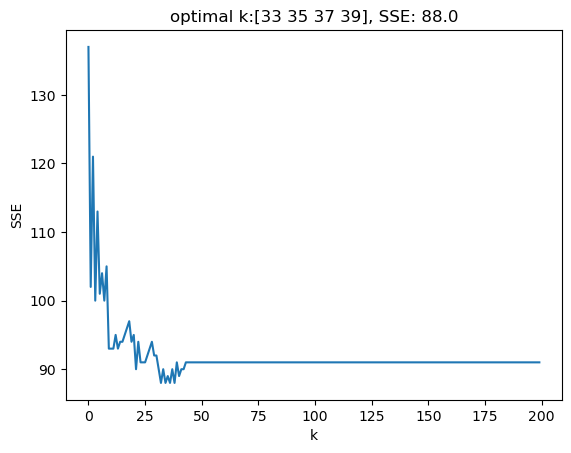

In [165]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier 
import matplotlib.pyplot as plt

k_bar = 200
SSE = np.zeros(k_bar)

# The Regressor warrants a k value with a lower minSSE than the classifier(72.56 vs. 88)
for k in range(k_bar):
  # fitted_model = KNeighborsRegressor(n_neighbors=k+1).fit(X_train,y_train) # Optimal k is 48
  fitted_model = KNeighborsClassifier(n_neighbors=k+1).fit(X_train,y_train)
  y_hat = fitted_model.predict(X_test)
  SSE[k] = np.sum((y_test - y_hat) **2)

minSSE = np.min(SSE)
minIndex = np.where(SSE == minSSE)
optimal_k = minIndex[0] + 1
print(optimal_k)

plt.plot(np.arange(0,k_bar),SSE) # Plot SSE by k
plt.xlabel("k")
plt.title(f"optimal k:{optimal_k}, SSE: {minSSE}")
plt.ylabel('SSE')
plt.show()

> Run the kNN classifier with the optimal $k$ value and determine its accuracy. 

In [180]:
model = KNeighborsClassifier(n_neighbors=33).fit(X_train,y_train)
y_hat = model.predict(X_test)
SSE_final = np.sum( (y_test-y_hat)**2 )

# Accuracy metric for classifier
accuracy = model.score(X_test,y_test)
print('Accuracy: ', accuracy)
print('SSE: ', SSE_final)

pd.crosstab(y_test, y_hat)
# plot, axes = plt.subplots()
# plt.scatter(y_test,y_hat)
# plt.title('k: '+str(40)+', SSE: '+str(SSE_final))
# axes.set_ylim(0, 1)
# axes.set_xlim(0, 1)
# plt.show()

Accuracy:  0.8616352201257862
SSE:  88


col_0,0,1
TenYearCHD,,
0,545,0
1,88,3


In [184]:
model = KNeighborsRegressor(n_neighbors=48).fit(X_train,y_train)
y_hat = model.predict(X_test)
# Accuracy metric for regressor
# mse = mean_squared_error(X_test, y_test)
r2 = model.score(X_test, y_test)

# print("Mean Squared Error:", mse)
print("R-squared:", r2)

R-squared: 0.06937306768155393


> 86% accuracy for the classifier is a lot better than the 7% $r^2$ of the regressor.

# Regression Tree

In [158]:
cart = DecisionTreeClassifier()
cart = cart.fit(X_train, y_train)

y_hat = cart.predict(X_test)

## Confusion Matrix
tab = pd.crosstab(y_test,y_hat) # Compute confusion matrix
acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy

print('Accuracy: ', acc, '\n')
pd.crosstab(y_test,y_hat)

Accuracy:  0.7672955974842768 



col_0,0,1
TenYearCHD,,
0,461,84
1,64,27


> The accuracy is a lot better than kNN, but is only around 77%.